In [52]:
# If running in Google Colab, mount drive
print('Check if running in Colab...')
try:
    from google.colab import drive
    print('Running in Colab!')
    drive.mount('/content/drive')
    %cd '/content/drive/My Drive/CIL-FS20'
except ImportError:
    print('Running locally!')

    #Check python version
    from platform import python_version
    print('Current python version: {}'.format(python_version()))

    # Check available GPUs
    import tensorflow as tf
    no_GPUs_available = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Number of GPUs Available: {}".format(no_GPUs_available))

Check if running in Colab...
Running in Colab!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CIL-FS20


In [53]:
import matplotlib
import numpy as np
import pandas as pd
import os,sys
import imageio
from PIL import Image
import cv2
import natsort
import random
import keras
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

import util.utility as util
import util.metrics as metrics

In [54]:
# Constants
MODEL_NAME = 'baseline2_model'
IMG_WIDTH = 608
IMG_HEIGHT = 608
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 2

# Fix random seeds for reproducibility
rnd_seed = 4
np.random.seed(rnd_seed)

## Load Data

In [55]:
training_image_dir = "training_images/images/"
training_label_dir = "training_images/groundtruth/"
test_image_dir = "test_images/normal/"

# Load filenames of training an test images
files_image = os.listdir(training_image_dir)
files_image = natsort.natsorted(files_image)[-100:]
files_label = os.listdir(training_label_dir)
files_label = natsort.natsorted(files_label)[-100:]
files_test = os.listdir(test_image_dir)
files_test = natsort.natsorted(files_test)

# Load Images and labels
training_image = util.load_images(training_image_dir, files_image, "RGB")
training_label = util.load_images(training_label_dir, files_label, "L")
test_image = util.load_images(test_image_dir, files_test, "RGB")

print("TRAINING:")
print(training_image.shape)
print(training_label.shape)
print("TEST:")
print(test_image.shape)

Loading 100 images
Loading 100 images
Loading 94 images
TRAINING:
(100, 400, 400, 3)
(100, 400, 400)
TEST:
(94, 608, 608, 3)


## Preprocessing

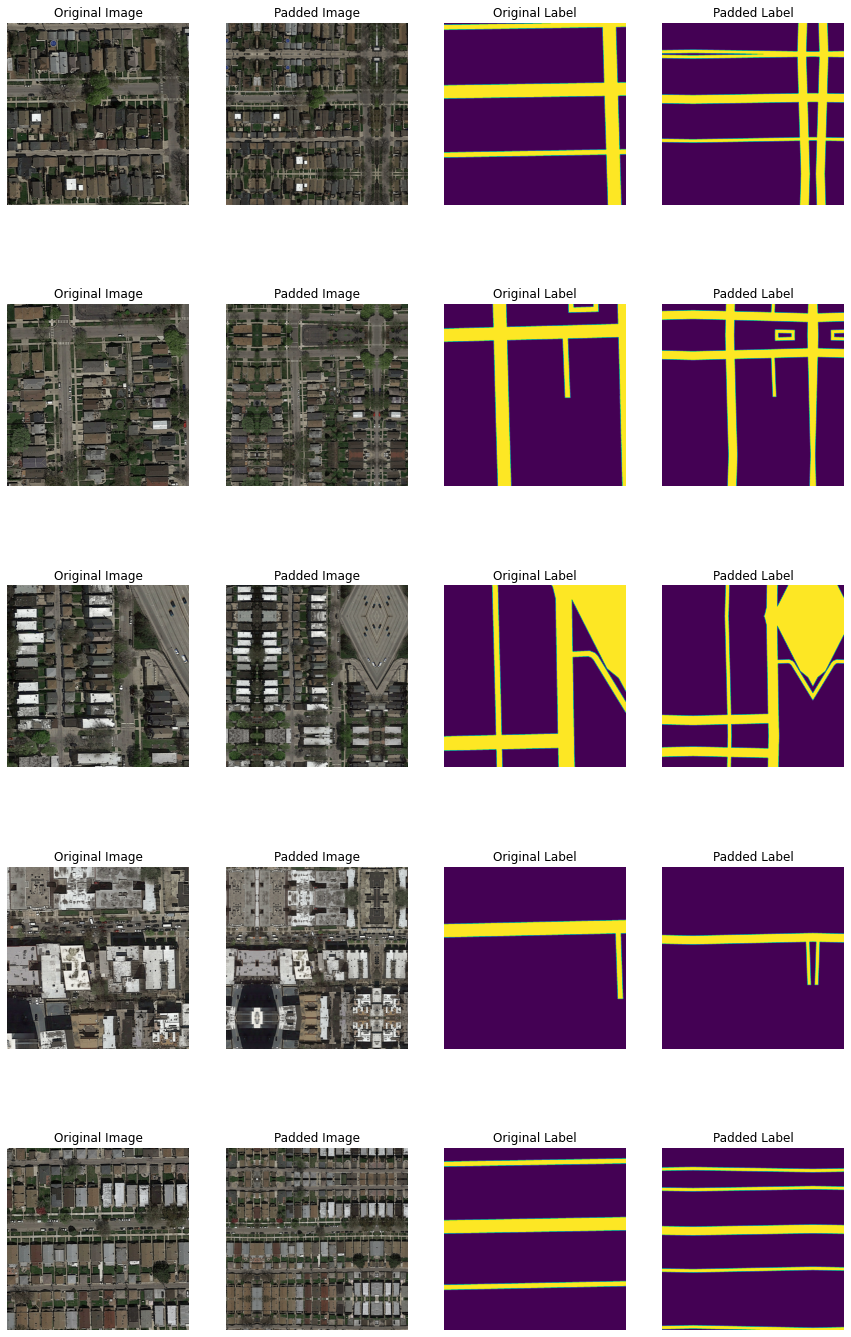

(100, 608, 608, 3)
(100, 608, 608, 1)


In [56]:
# Mirror padd all training images to get same size as test images
training_image_padded = util.padd_images(training_image, 608, 608).astype(np.uint8)
training_label_padded = util.padd_images(training_label, 608, 608).astype(np.uint8)

# Plot random Sample of images
n = training_image.shape[0]
index = random.randint(0, n-1)
num_samples = 5

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  index = random.randint(0, n-1)

  f.add_subplot(num_samples, 4, i)
  plt.imshow(training_image[index])
  plt.title("Original Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  plt.imshow(training_image_padded[index])
  plt.title("Padded Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  plt.imshow(np.squeeze(training_label[index]))
  plt.title("Original Label")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  plt.imshow(np.squeeze(training_label_padded[index]))
  plt.title("Padded Label")
  plt.axis('off')

plt.show()

# Rescale images
training_image = training_image_padded.astype(np.float32)/255.0
training_label = training_label_padded.astype(np.float32)/255.0
test_image = test_image.astype(np.float32)/255.0
training_label = np.expand_dims(training_label, -1)
print(training_image.shape)
print(training_label.shape)

# Get a validation set
training_image, validation_image, training_label, validation_label = train_test_split(
    training_image, training_label, test_size=0.1, random_state=rnd_seed)

## Model: U-Net built in Keras

In [57]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 608, 608, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 608, 608, 16) 64          conv2d_77[0][0]                  
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 608, 608, 16) 0           batch_normalization_73[0][0]     
____________________________________________________________________________________________

## Model Compilation

In [58]:
model_path = "./Models/{}_model.h5".format(MODEL_NAME)
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
csv_logger = CSVLogger("./Logs/{}_log.csv".format(MODEL_NAME), separator=',', append=False)
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=6,
                               verbose=1,
                               epsilon=1e-4)
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

opt = keras.optimizers.Adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=metrics.dice_coef_loss,
      metrics=[metrics.iou_coef])

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


## Model Training

In [59]:
history = model.fit(training_image,
                    training_label,
                    validation_data =(validation_image, validation_label),
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, csv_logger, lr_reducer, early_stopper])

Train on 90 samples, validate on 10 samples
Epoch 1/100
90/90 [==============================] - 27s 305ms/step - loss: 0.1746 - iou_coef: 0.1858 - val_loss: 0.3821 - val_iou_coef: 0.1833

Epoch 00001: val_loss improved from inf to 0.38207, saving model to ./Models/baseline2_model_model.h5
Epoch 2/100
90/90 [==============================] - 22s 247ms/step - loss: 0.1304 - iou_coef: 0.2581 - val_loss: 0.4015 - val_iou_coef: 0.1806

Epoch 00002: val_loss did not improve from 0.38207
Epoch 3/100
90/90 [==============================] - 22s 246ms/step - loss: 0.0977 - iou_coef: 0.3060 - val_loss: 0.3870 - val_iou_coef: 0.1833

Epoch 00003: val_loss did not improve from 0.38207
Epoch 4/100
90/90 [==============================] - 22s 246ms/step - loss: 0.0804 - iou_coef: 0.3391 - val_loss: 0.3779 - val_iou_coef: 0.1857

Epoch 00004: val_loss improved from 0.38207 to 0.37792, saving model to ./Models/baseline2_model_model.h5
Epoch 5/100
90/90 [==============================] - 22s 246ms/ste

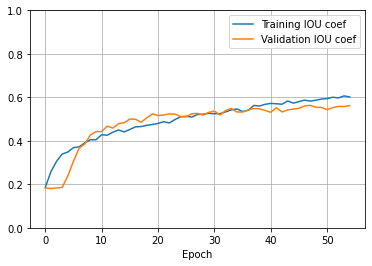

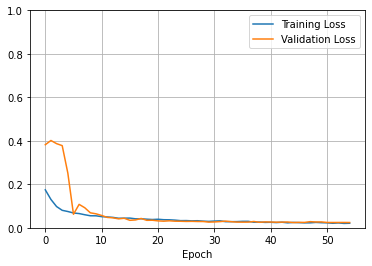

In [60]:
# Show a training report
training_info = pd.read_csv('./Logs/{}_log.csv'.format(MODEL_NAME), header=0)

acc1, = plt.plot(training_info['epoch'], training_info['iou_coef'])
acc2, = plt.plot(training_info['epoch'], training_info['val_iou_coef'])
plt.legend([acc1, acc2], ['Training IOU coef', 'Validation IOU coef'])
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.grid(True)
plt.show()

loss1, = plt.plot(training_info['epoch'], training_info['loss'])
loss2, = plt.plot(training_info['epoch'], training_info['val_loss'])
plt.legend([acc1, acc2], ['Training Loss', 'Validation Loss'])                            
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.grid(True)

plt.show()

## Model Evaluation

In [61]:
model = load_model("./Models/{}_model.h5".format(MODEL_NAME), custom_objects={'dice_coef_loss': metrics.dice_coef_loss, 'iou_coef': metrics.iou_coef})
predictions = model.predict(test_image, verbose=1, batch_size=1)

94/94 [==============================] - 6s 65ms/step


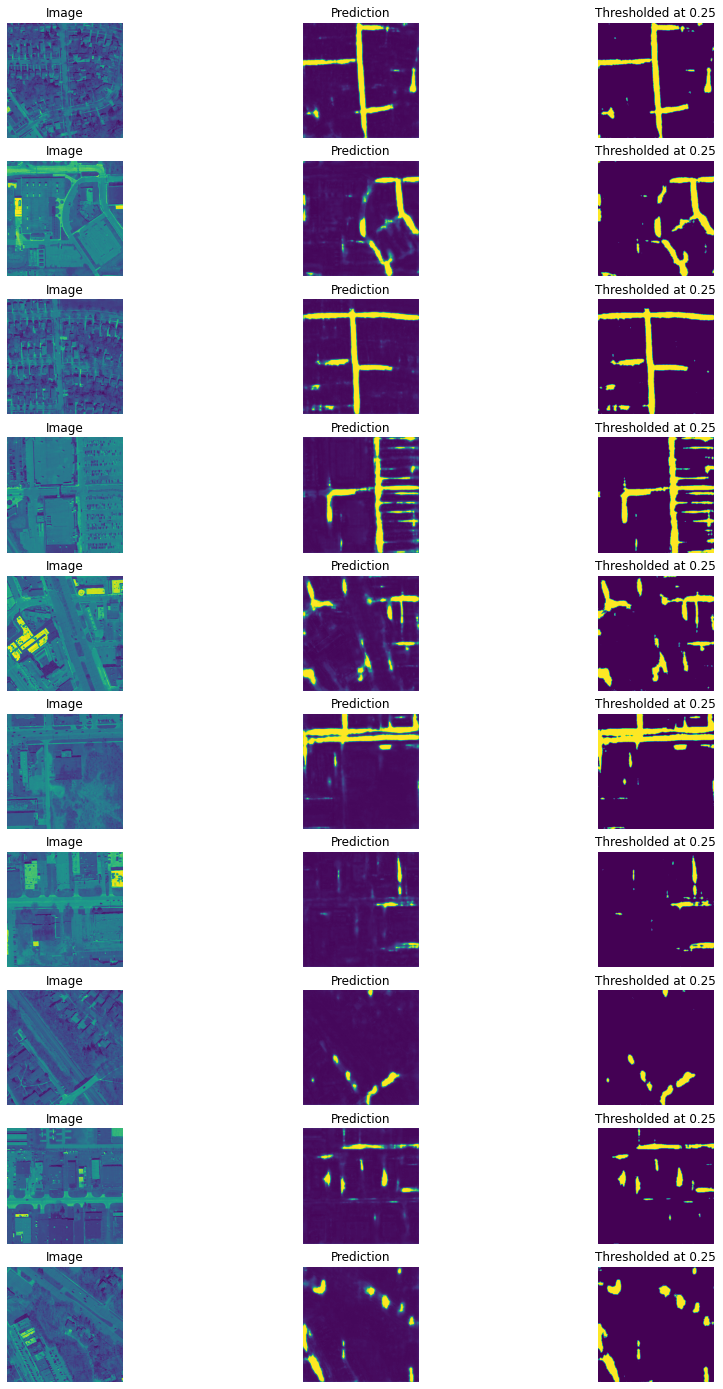

In [62]:
# Plot Predictions
thresh_val = 0.25
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

index = random.randint(0, len(predictions)-1)
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*3, 3):
  index = random.randint(0, len(predictions)-1)

  f.add_subplot(num_samples, 3, i)
  plt.imshow(test_image[index][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+1)
  plt.imshow(np.squeeze(predictions[index][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+2)
  plt.imshow(np.squeeze(predicton_threshold[index][:,:,0]))
  plt.title("Thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()

## Create Submission File

In [63]:
result_dir = './Results/Prediction_Images/{}/'.format(MODEL_NAME)
submission_filename = './Results/Submissions/{}.csv'.format(MODEL_NAME)
util.create_submission(predictions, result_dir, submission_filename, files_test)

./Results/Prediction_Images/baseline2_model/test_7.png
./Results/Prediction_Images/baseline2_model/test_8.png
./Results/Prediction_Images/baseline2_model/test_9.png
./Results/Prediction_Images/baseline2_model/test_10.png
./Results/Prediction_Images/baseline2_model/test_11.png
./Results/Prediction_Images/baseline2_model/test_12.png
./Results/Prediction_Images/baseline2_model/test_14.png
./Results/Prediction_Images/baseline2_model/test_15.png
./Results/Prediction_Images/baseline2_model/test_21.png
./Results/Prediction_Images/baseline2_model/test_23.png
./Results/Prediction_Images/baseline2_model/test_25.png
./Results/Prediction_Images/baseline2_model/test_26.png
./Results/Prediction_Images/baseline2_model/test_27.png
./Results/Prediction_Images/baseline2_model/test_29.png
./Results/Prediction_Images/baseline2_model/test_36.png
./Results/Prediction_Images/baseline2_model/test_40.png
./Results/Prediction_Images/baseline2_model/test_41.png
./Results/Prediction_Images/baseline2_model/test_49